# 한국어 데이터로 챗봇 만들기

In [240]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

---

# 데이터 수집 & 전처리

(송영숙님이 공개한 챗봇 데이터를 사용합니다)

In [241]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [242]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (ㄱ-ㅎ, 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [243]:
filepath = os.path.join(os.getenv("HOME"), 'aiffel/transformer_chatbot/data', 'ChatbotData .csv')
data = pd.read_csv(filepath)

questions, answers = [], []
for q, a in zip(data['Q'], data['A']):
    questions.append(preprocess_sentence(q))
    answers.append(preprocess_sentence(a))

In [244]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[22]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 가장 확실한 시간은 오늘이에요 . 어제와 내일을 놓고 고민하느라 시간을 낭비하지 마세요 .


In [245]:
len(questions)

11823

### 문장 분석

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 57
텍스트의 평균 길이 : 13.177619893428064
요약의 최소 길이 : 1
요약의 최대 길이 : 78
요약의 평균 길이 : 16.03129493360399


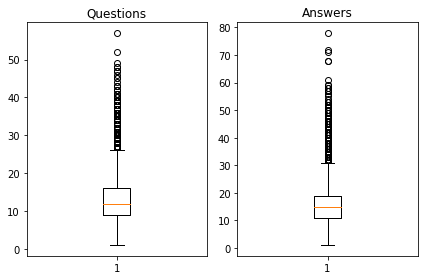

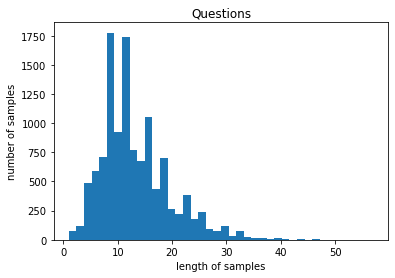

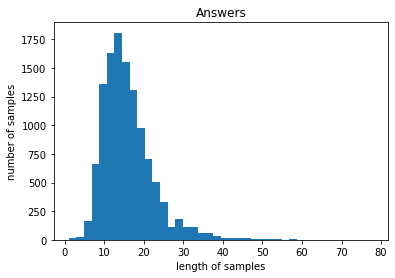

In [246]:
question_len = [len(s) for s in questions]
answer_len = [len(s) for s in answers]

print('텍스트의 최소 길이 : {}'.format(np.min(question_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(question_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(question_len)))
print('요약의 최소 길이 : {}'.format(np.min(answer_len)))
print('요약의 최대 길이 : {}'.format(np.max(answer_len)))
print('요약의 평균 길이 : {}'.format(np.mean(answer_len)))

plt.subplot(1,2,1)
plt.boxplot(question_len)
plt.title('Questions')

plt.subplot(1,2,2)
plt.boxplot(answer_len)
plt.title('Answers')
plt.tight_layout()
plt.show()

plt.title('Questions')
plt.hist(question_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Answers')
plt.hist(answer_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

##### 한국어에 맞는 최대길이를 찾기 위해 데이터를 확인했습니다.

- Question
    - 평균 13
    - 최대 57
- Answer
    - 평균 16
    - 최대 78

각 데이터는 위와 같았습니다.

Question과 Answer이 한 쌍으로 무조건 같이 들어가기 때문에

적절한 수준에서 최대길이를 설정하는 것이 좋을 거라 판단했고, 특정 길이일 때 샘플의 비율을 확인했습니다.

In [247]:
def below_threshold_len(max_len, data_list):
    cnt = 0
    for s in data_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(data_list))))

In [248]:
questions_max_len = 30
answers_max_len = 30

below_threshold_len(questions_max_len, questions)
below_threshold_len(answers_max_len,  answers)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 0.9822380106571936
전체 샘플 중 길이가 30 이하인 샘플의 비율: 0.9625306605768418


#### 위 그래프와 샘플 비율을 통해 max_len을 30으로 설정했습니다.

---

# SubwordTextEncoder 사용

In [249]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [250]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [251]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8135]
END_TOKEN의 번호 : [8136]


In [252]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8137


---

# 정수 인코딩 & 패딩

In [253]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 30
print(MAX_LENGTH)

30


In [254]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print(questions[21])
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print(answers[21])
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

가스비 장난 아님
정수 인코딩 후의 21번째 질문 샘플: [5744, 610, 2485, 4149]
다음 달에는 더 절약해봐요 .
정수 인코딩 후의 21번째 답변 샘플: [2353, 7486, 7, 6252, 97, 1]


In [255]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대 길이 25 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
            
    # 최대 길이 325으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [256]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8137
필터링 후의 질문 샘플 개수: 11822
필터링 후의 답변 샘플 개수: 11822


In [257]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    }
))
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

---

# 모델 구성

### PositionalEncoding

In [258]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Scaled dot project attention

In [259]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트 (q와 k의 내적))
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

### MultiHeadAttention

In [260]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name='multi_head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads # ex: 8
        self.d_model = d_model # ex: 512
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads # ex: 64
        
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        
        self.dense = tf.keras.layers.Dense(units=d_model)
        
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # reshape의 -1은 행렬 크기에 맞춰서 추론되어 자동 결정됨 
        return tf.transpose(inputs, perm=[0,2,1,3])
    
    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        
        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)
        
        return outputs

### Padding Mask

In [261]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### Look-ahead Mask

In [262]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask) # padding_mask에서 원 값이 0인 경우 1로 설정하기 때문에 -> 1 값을 골라는 것임

### 인코더 레이어

In [263]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더 레이어

In [264]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [265]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    
    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    
    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs) # 두번째 어텐션 블록에서 인코더-디코더 어텐션을 하기 때문에 인코더에 들어가는 inputs기준 패딩 마스크

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 손실 함수

In [266]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 커스텀 된 학습률

In [267]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 모델 생성

In [268]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3137280     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

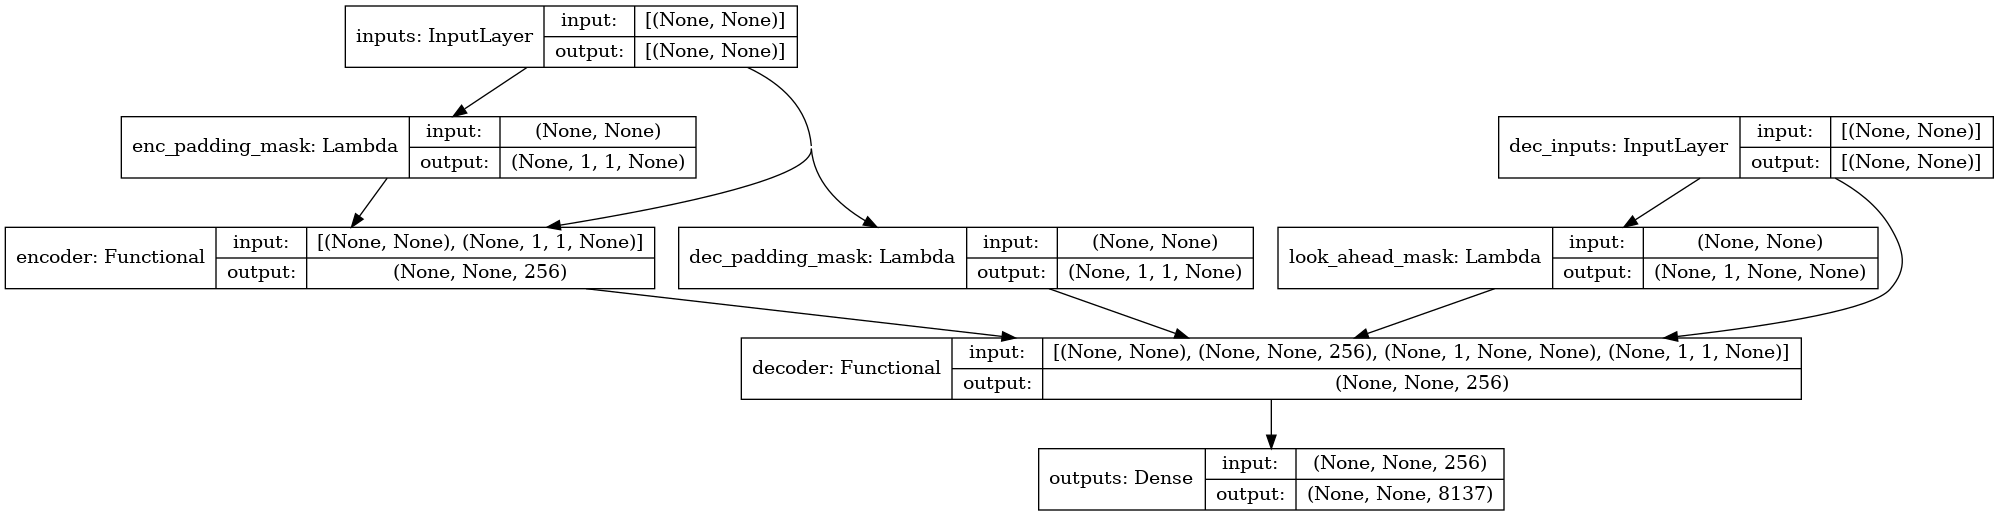

In [294]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

---

# 모델 훈련

In [269]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [270]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 13s 44ms/step - loss: 1.9552 - accuracy: 0.0267
Epoch 2/20
185/185 [==============================] - 8s 44ms/step - loss: 1.5866 - accuracy: 0.0641
Epoch 3/20
185/185 [==============================] - 8s 44ms/step - loss: 1.3547 - accuracy: 0.0679
Epoch 4/20
185/185 [==============================] - 8s 44ms/step - loss: 1.2493 - accuracy: 0.0726
Epoch 5/20
185/185 [==============================] - 8s 44ms/step - loss: 1.1685 - accuracy: 0.0776
Epoch 6/20
185/185 [==============================] - 8s 44ms/step - loss: 1.0870 - accuracy: 0.0832
Epoch 7/20
185/185 [==============================] - 8s 44ms/step - loss: 0.9970 - accuracy: 0.0913
Epoch 8/20
185/185 [==============================] - 8s 44ms/step - loss: 0.8981 - accuracy: 0.1021
Epoch 9/20
185/185 [==============================] - 8s 44ms/step - loss: 0.7919 - accuracy: 0.1135
Epoch 10/20
185/185 [==============================] - 8s 44ms/step - loss: 0.6804 - accur

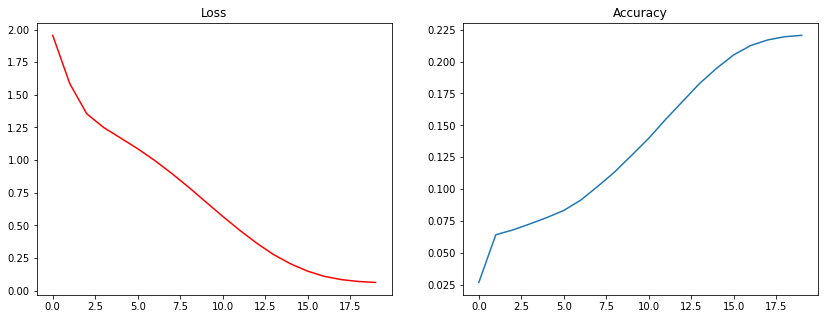

In [271]:
plt.figure(figsize=(14, 5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], c='r')
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.show()

---

# 모델 평가

In [272]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수??
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [273]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

### 어울리는 답변들

In [286]:
sentence_generation("뭐 먹을까?")

입력 : 뭐 먹을까?
출력 : 좀 먹어도 괜찮아요 .


'좀 먹어도 괜찮아요 .'

In [292]:
sentence_generation("영화 추천해줘")

입력 : 영화 추천해줘
출력 : 최신 영화가 좋을 것 같아요 .


'최신 영화가 좋을 것 같아요 .'

In [276]:
sentence_generation("사랑이 뭘까?")

입력 : 사랑이 뭘까?
출력 : 사랑은 알 수 없어요 . 단지 느껴질 뿐 .


'사랑은 알 수 없어요 . 단지 느껴질 뿐 .'

In [278]:
sentence_generation("영화 보고싶어")

입력 : 영화 보고싶어
출력 : 그럴 때가 있어요 .


'그럴 때가 있어요 .'

In [279]:
sentence_generation("너 이름이 뭐야?")

입력 : 너 이름이 뭐야?
출력 : 위로봇이요 .


'위로봇이요 .'

### 이상한 답변들

In [280]:
sentence_generation("내일 날씨는 어때?")

입력 : 내일 날씨는 어때?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [277]:
sentence_generation("존똑이야")

입력 : 존똑이야
출력 : 잘 지냈답니다 .


'잘 지냈답니다 .'

In [281]:
sentence_generation('오늘 많이 힘들었어')

입력 : 오늘 많이 힘들었어
출력 : 차라리 잘 된 일이네요 .


'차라리 잘 된 일이네요 .'

In [282]:
sentence_generation('지금 몇시야?')

입력 : 지금 몇시야?
출력 : 잘 맞춰가면 돼요 .


'잘 맞춰가면 돼요 .'

### 이상하게 던진 질문에 대한 답변들

In [283]:
sentence_generation('ㅋㅋㅋㅋㅋㅋㅋㅋ')

입력 : ㅋㅋㅋㅋㅋㅋㅋㅋ
출력 : 좋은 연락이었길 바랍니다 .


'좋은 연락이었길 바랍니다 .'

In [284]:
sentence_generation('222222')

입력 : 222222
출력 : 저는 위로해드리는 로봇이에요 .


'저는 위로해드리는 로봇이에요 .'

In [293]:
sentence_generation('???')

입력 : ???
출력 : 상대방이 알 거예요 .


'상대방이 알 거예요 .'

---

# 회고

### 개선점

1. 정규표현식에 한국어 전처리를 변경 적용 (ㄱ-ㅎ, 가-힣 을 추가)

2. 문장 최대 길이 분포를 확인하고, 한국어에 맞춰 최대 길이를 조정했습니다.


### 챗봇 테스트 결과

1. loss, accuracy 시각화를 통해 점차 성능이 안정적으로 좋아지는 것을 확인할 수 있었습니다.
2. 답변은 대체적으로 적절한 답변과 이상한 답변 모두 도출하고 있습니다.
3. 이상한 질문에 대해서 답변을 하긴 하지만 적절하지 않습니다.
4. 영어를 제외했을 땐 답변이 빈 문자열이었습니다. 학습되지 않은 문장에 대해서는 답변하지 못한다는 점을 알 수 있었습니다.

### 느낀 점
- 확실히 더 좋은 답변을 위해서는 더 많은 데이터가 필요하다고 생각합니다.